# Creating a Notes Sentiment Score

#### Configure Spark and import all necessary libraries

In [171]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
         }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1618550986815_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1618550986815_0002,pyspark,idle,Link,Link,None,✔


In [173]:
sc.install_pypi_package("vaderSentiment")
sc.install_pypi_package("pandas")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
Package already installed for current Spark context!
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/context.py", line 1110, in install_pypi_package
    raise ValueError("Package already installed for current Spark context!")
ValueError: Package already installed for current Spark context!



In [3]:
sc.uninstall_package("setuptools")
sc.install_pypi_package("setuptools==54.0.0")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Uninstalling setuptools-28.8.0:
  Successfully uninstalled setuptools-28.8.0

  Found existing installation: setuptools 38.4.0
    Not uninstalling setuptools at /usr/lib/python3.7/site-packages, outside environment /tmp/1618553487780-0

In [184]:
sc.install_pypi_package("pyarrow==0.14.1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/48/ab/8691c96c81e8a8493e26314a99efcdde97b9ed9c1e5cd705e97d15e79502/pyarrow-0.14.1-cp37-cp37m-manylinux1_x86_64.whl

In [185]:
sc.install_pypi_package('boto3')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/62/b3/8c889dd3d5ae47a9c4468cc20ef980adc4a16f06f0937ab33f78b58b5eda/boto3-1.17.53-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/92/4e/232e261b739534e216f28d935a06c44840221c3476ebcdb411cd0fc2bf16/botocore-1.20.53-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/00/89/0cb4e92c239e6425b9b0035227b8cdf9d3d098a5c9e95632c3815df63a09/s3transfer-0.3.7-py2.py3-none-any.whl

In [239]:
sc.install_pypi_package("matplotlib")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import boto3
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.window import Window
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer= SentimentIntensityAnalyzer()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Pull the Data

In [176]:
df_notes=spark.read.parquet('s3://mimic-iii-physionet/parquet/NOTEEVENTS/')
df_admissions=spark.read.parquet('s3://mimic-iii-physionet/parquet/ADMISSIONS/')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [177]:
df_admissions.select('subject_id','hadm_id').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

58976

In [178]:
df_notes_admin=df_notes.join(df_admissions,["hadm_id","subject_id"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [179]:
df_notes_admin.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['hadm_id', 'subject_id', 'row_id', 'chartdate', 'charttime', 'storetime', 'category', 'description', 'cgid', 'iserror', 'text', 'row_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data']

In [180]:
df_notes_admin.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1851344

In [181]:
df_notes_admin.select('subject_id','hadm_id').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

58361

#### Filter Data for Relevant HADM Stays

In [186]:
bucket='allstays' # Or whatever you called your bucket
data_key = 'all_stays.csv' # Where the file is within your bucket
data_location = 's3://{}/{}'.format(bucket, data_key)
df = spark.read.option("header",True).csv(data_location)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [187]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LAST_CAREUNIT', 'DBSOURCE', 'INTIME', 'OUTTIME', 'LOS', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ETHNICITY', 'DIAGNOSIS', 'GENDER', 'DOB', 'DOD', 'AGE', 'MORTALITY_INUNIT', 'MORTALITY', 'MORTALITY_INHOSPITAL']

In [188]:
df_hadm = df.select("SUBJECT_ID","HADM_ID").withColumnRenamed("SUBJECT_ID","subject_id").withColumnRenamed("HADM_ID","hadm_id")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [189]:
df_notes_admin=df_notes_admin.select("*").join(df_hadm,["hadm_id","subject_id"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [190]:
df_notes_admin.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1040922

In [191]:
w2 = Window.partitionBy([F.col("subject_id"),F.col("hadm_id")]).orderBy([F.col("subject_id").asc_nulls_last(),F.col("hadm_id").asc_nulls_last(),F.col('chartdate').asc_nulls_last(),F.col("charttime").asc_nulls_last(),F.col('storetime').asc_nulls_last()])
df_notes_admin_filt=df_notes_admin.withColumn("row",F.row_number().over(w2)).where(F.col("row") == 1).drop(F.col("row"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df_notes_admin.select('subject_id','hadm_id').distinct().count()

#### Create Sentiment Column

In [192]:
@pandas_udf('double',PandasUDFType.SCALAR)
def sentiment_create(x: pd.Series)->pd.Series:
    return x.map(lambda v: analyzer.polarity_scores(v)['compound'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [193]:
df_notes_admin_filt = df_notes_admin_filt.withColumn("notes_sentiment",sentiment_create(F.col("text")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [235]:
df_notes_admin_filt = df_notes_admin_filt.withColumn("notes_sentiment_grouped",F.when(F.col("notes_sentiment")>.05,"Positive")
                                .when(F.col("notes_sentiment")<-.05,"Negative")
                                .otherwise("Neutral"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Note:** Something to come back to - do we want to keep only a certain type of note? For now just keep first recorded note.

In [167]:
df_notes_admin.select("description").distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|         description|
+--------------------+
|Physical Therapy ...|
|Physician Residen...|
|Overnight Intensi...|
|Physical Therapy ...|
|Critical Care Att...|
|Critical Care Att...|
|    HCP Phone number|
|MICU Attending Ad...|
|  Cardioversion note|
|MICU staff progre...|
|Resident Progress...|
| PGY 1 progress note|
|Cancelled Video S...|
|Case Management D...|
|Green Dye Bedside...|
|Respiratory Care ...|
|      Resp.Care note|
|Communication Eva...|
|Right knee aspira...|
|    Respiratory CAre|
+--------------------+
only showing top 20 rows

#### Notes Sentiment Basic EDA

In [243]:
x=df_notes_admin_filt.groupBy('hadm_id',"notes_sentiment_grouped").count().select('notes_sentiment_grouped').toPandas()
plt.cla()
ax=x.value_counts().plot(kind='bar',legend=False)
ax.set_xlabel("Notes Sentiment Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
#ax.get_legend().remove()
rects = ax.patches[:6]
ax.set_xticklabels(['Positive','Negative','Neutral'],rotation=45)

#print(rects)

# Make some labels.
labels = ["{:,d}".format(i) for i in x.value_counts()]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.title("Count of Notes Sentiment Type per Admission")
plt.tight_layout()
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

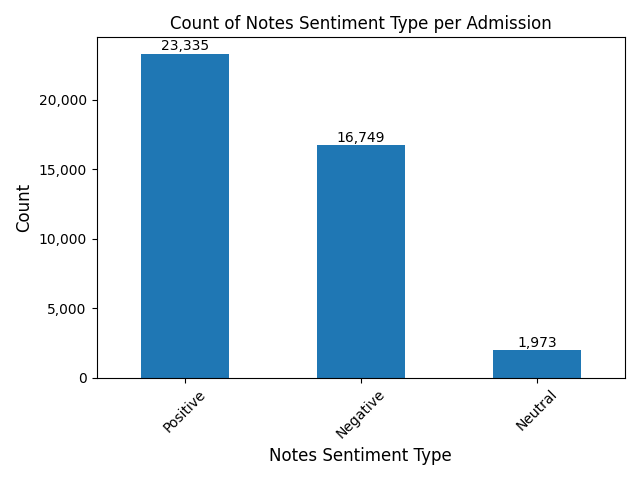

In [244]:
%matplot plt

#### Notes Sentiment Data to CSV

In [245]:
df_csv = df_notes_admin_filt.select("subject_id","hadm_id","notes_sentiment","notes_sentiment_grouped","chartdate").toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [246]:
df_csv['episode_count']=df_csv.groupby(["subject_id"])['chartdate'].rank()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [249]:
df_csv['filename']=df_csv.apply(lambda x: str(x["subject_id"])+"_episode"+str(int(x['episode_count']))+"_timeseries.csv",axis=1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [250]:
df_csv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       subject_id  hadm_id  ...  episode_count                       filename
0              36   182104  ...            1.0     36_episode1_timeseries.csv
1              44   181750  ...            1.0     44_episode1_timeseries.csv
2              95   160891  ...            1.0     95_episode1_timeseries.csv
3             100   153952  ...            1.0    100_episode1_timeseries.csv
4             136   184644  ...            1.0    136_episode1_timeseries.csv
...           ...      ...  ...            ...                            ...
42052       98342   103844  ...            2.0  98342_episode2_timeseries.csv
42053       98588   129749  ...            1.0  98588_episode1_timeseries.csv
42054       98724   186754  ...            1.0  98724_episode1_timeseries.csv
42055       99085   178854  ...            3.0  99085_episode3_timeseries.csv
42056       99781   147562  ...            2.0  99781_episode2_timeseries.csv

[42057 rows x 7 columns]

In [252]:
from io import StringIO # python3; python2: BytesIO 

bucket = 'allstays' # already created on S3
csv_buffer = StringIO()
df_csv.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'notes_sentiment_data.csv').put(Body=csv_buffer.getvalue())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ResponseMetadata': {'RequestId': 'KEW9GA7JRRM52CW2', 'HostId': '37XjPBSemgNhXAyZfAASw2bZs7CG1Qz/rrc/WIzWmTHt8B6hVAhTl8yZcGbc7ZGoUzpGEwDVcT0=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': '37XjPBSemgNhXAyZfAASw2bZs7CG1Qz/rrc/WIzWmTHt8B6hVAhTl8yZcGbc7ZGoUzpGEwDVcT0=', 'x-amz-request-id': 'KEW9GA7JRRM52CW2', 'date': 'Fri, 16 Apr 2021 12:04:28 GMT', 'etag': '"457b132d8407624ea9045333d48e2743"', 'content-length': '0', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'ETag': '"457b132d8407624ea9045333d48e2743"'}